# Homework



In [1]:
# Update torch, torchvision and numpy
!pip install -U torch torchvision numpy opencv-python

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.3)
     |████████████████████████████████| 28.2MB 130kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
# Homework dataset
!wget http://deeplearning.iit.bme.hu/CVS/HW.zip
!unzip -qq HW.zip
!rm HW.zip

# Traffic Sign Classification set
!wget http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
!unzip -qq trafficSignsHW.zip
!rm trafficSignsHW.zip

--2020-04-29 12:07:14--  http://deeplearning.iit.bme.hu/CVS/HW.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14450183 (14M) [application/zip]
Saving to: ‘HW.zip’

HW.zip              100%[===================>]  13.78M  4.12MB/s    in 3.3s    

2020-04-29 12:07:21 (4.12 MB/s) - ‘HW.zip’ saved [14450183/14450183]

--2020-04-29 12:07:26--  http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
Resolving deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)... 152.66.243.112
Connecting to deeplearning.iit.bme.hu (deeplearning.iit.bme.hu)|152.66.243.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175675617 (168M) [application/zip]
Saving to: ‘trafficSignsHW.zip’

trafficSignsHW.zip  100%[===================>] 167.54M  7.91MB/s    in 22s     

2020-04-29 12:07:50 (7.49 MB/s) - ‘traff

In [3]:
# Install homework repository
!git clone https://github.com/szykry/CVML_HW.git

Cloning into 'CVML_HW'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 66 (delta 27), reused 45 (delta 13), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [4]:
# Set root folder
import os
name = "/content/CVML_HW/"
os.chdir(name)
!pwd

/content/CVML_HW


In [0]:
# Evaluation
from HW.evaluate import evaluate

# file = open('HW/annotations.pickle','rb')
# predictions = pickle.load(file)

evaluate(predictions)

FileNotFoundError: ignored

# Tradition



In [0]:
# https://docs.opencv.org/4.3.0/d1/d1a/namespacecv_1_1cuda.html

# Tábla -> hough
# szegmentális
# cv.threshold


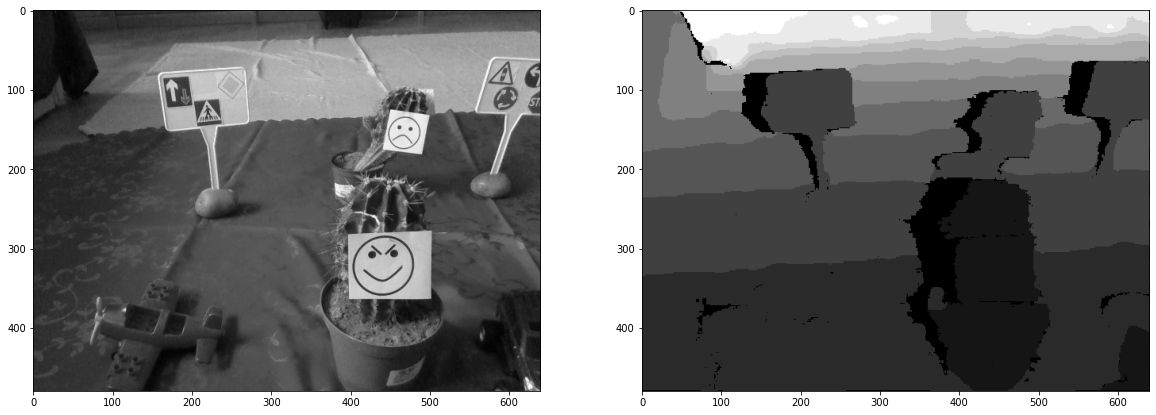

In [5]:
#OpenCV
import cv2

#Numpy - numeric library
import numpy as np

#Plotting
import matplotlib.pyplot as plt

#This way it doesn't try to open a window un the GUI - works in python notebook
%matplotlib inline

minVal=0.0
maxVal=0.0

img = cv2.imread("../HW/g3/rgb/1.jpg")   # 2.param: RGB, Grayscale, Bináriskép
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
minVal, maxVal, _, _ = cv2.minMaxLoc(img_gray)    # hol vannak a szélsőértékek
res=img_gray
cv2.convertScaleAbs(img_gray,res,255/(maxVal-minVal),-minVal)  # affin -> kép*alfa + béta

depth_img = cv2.imread("../HW/g3/depth/1.png")
depth_img_gray = cv2.cvtColor(depth_img, cv2.COLOR_BGR2GRAY)
minVal, maxVal, _, _ = cv2.minMaxLoc(depth_img_gray)    # hol vannak a szélsőértékek
depth_res=depth_img_gray
cv2.convertScaleAbs(depth_img_gray,depth_res,255/(maxVal-minVal),-minVal)  # affin -> kép*alfa + béta

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(res,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(depth_res,cmap='gray')


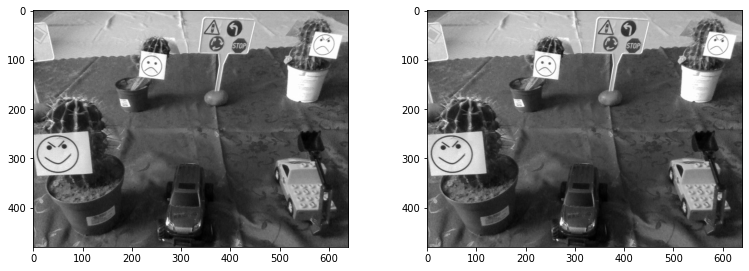

In [6]:

rowSubplot = 4
colSubplot = 3


plt.figure(figsize=(20,20))
imgBGR = cv2.imread("../HW/g3/rgb/136.jpg")
grayimg = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)
minVal,maxVal,_,_ = cv2.minMaxLoc(grayimg)
plt.subplot(rowSubplot,colSubplot,1)
plt.imshow(grayimg,cmap='gray')

res=grayimg
cv2.convertScaleAbs(grayimg,res,255.0/(maxVal-minVal),-minVal)
plt.subplot(rowSubplot,colSubplot,2)
plt.imshow(res,cmap='gray')


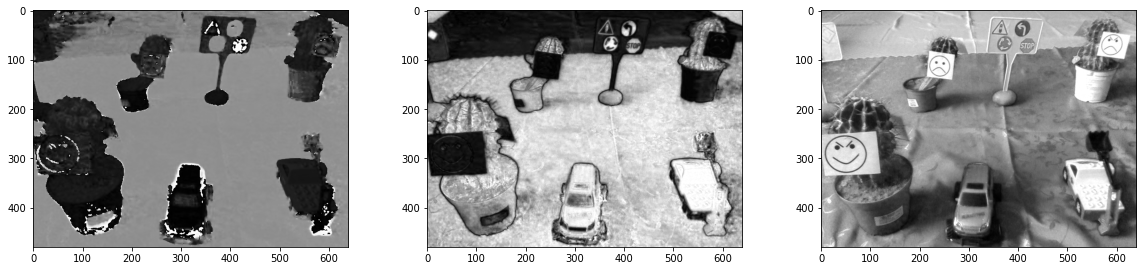

In [7]:

imgHSV = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2HSV);
hue_channel = imgHSV[:,:,0]
saturation_channel = imgHSV[:,:,1]
value_channel = imgHSV[:,:,2]
plt.figure(figsize=(20,20))
plt.subplot(rowSubplot,colSubplot,4)
plt.imshow(hue_channel,cmap='gray')
plt.subplot(rowSubplot,colSubplot,5)
plt.imshow(saturation_channel,cmap='gray')
plt.subplot(rowSubplot,colSubplot,6)
plt.imshow(value_channel,cmap='gray')


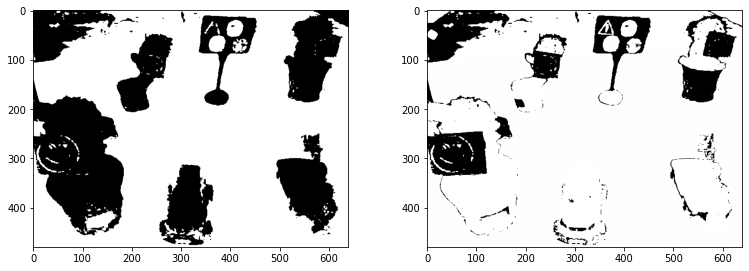

In [8]:

avg_hue = np.average(hue_channel)
hue_channel_thresh, hue_channel_segment = cv2.threshold(hue_channel,avg_hue,255,cv2.THRESH_BINARY)
plt.figure(figsize=(20,20))
plt.subplot(rowSubplot,colSubplot,10)
plt.imshow(hue_channel_segment,cmap='gray')

avg_saturation = np.average(saturation_channel)
saturation_channel_thresh, saturation_channel_segment = cv2.threshold(saturation_channel,(avg_saturation)/2,255,cv2.THRESH_BINARY)
plt.subplot(rowSubplot,colSubplot,11)
plt.imshow(saturation_channel_segment+hue_channel_segment,cmap='gray')


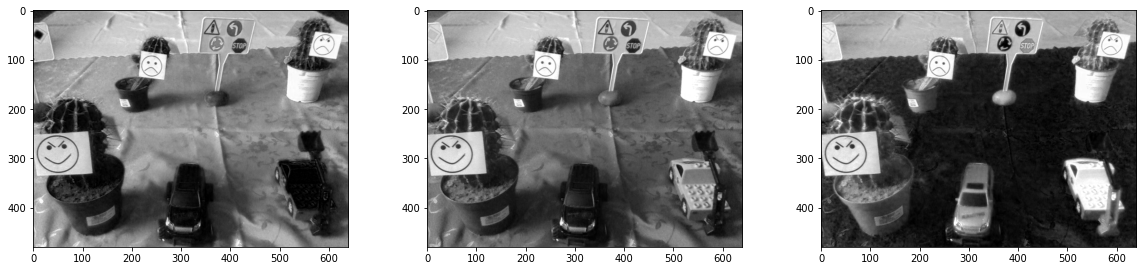

In [9]:

plt.figure(figsize=(20,20))

blue_channel = imgBGR[:,:,0]
green_channel = imgBGR[:,:,1]
red_channel = imgBGR[:,:,2]
plt.subplot(rowSubplot,colSubplot,7)
plt.imshow(blue_channel,cmap='gray')
plt.subplot(rowSubplot,colSubplot,8)
plt.imshow(green_channel,cmap='gray')
plt.subplot(rowSubplot,colSubplot,9)
plt.imshow(red_channel,cmap='gray')


In [10]:
# Get all subfolders in a directory
import os
path = name+"../HW/g3/rgb"
myFolderList = [f.path for f in os.scandir(path) if f.is_dir()]
print(myFolderList)

[]


In [11]:
# Get all files with extension in a directory
import glob
import re
 
def sorted_nicely( l ):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)
 
names = sorted_nicely(glob.glob1(path, "*.jpg"))
print(names)

['1.jpg', '65.jpg', '77.jpg', '136.jpg', '153.jpg', '189.jpg', '208.jpg', '225.jpg', '250.jpg', '278.jpg', '292.jpg', '307.jpg', '327.jpg', '340.jpg', '356.jpg', '376.jpg', '409.jpg', '420.jpg', '441.jpg']


In [0]:
# Class names
classNames = ['traffic sign', 'vehicle', 'cactus']
subclassNames = [
    ['Bump', 'Bumpy road', 'Bus stop', 'Children', 'Crossing (blue)', 'Crossing (red)', 'Cyclists',
     'Danger (other)', 'Dangerous left turn', 'Dangerous right turn', 'Give way', 'Go ahead', 'Go ahead or left',
     'Go ahead or right', 'Go around either way', 'Go around left', 'Go around right', 'Intersection', 'Limit 100',
     'Limit 120', 'Limit 20', 'Limit 30', 'Limit 50', 'Limit 60', 'Limit 70', 'Limit 80', 'Limit 80 over',
     'Limit over', 'Main road', 'Main road over', 'Multiple dangerous turns', 'Narrow road (left)',
     'Narrow road (right)', 'No entry', 'No entry (both directions)', 'No entry (truck)', 'No stopping', 'No takeover',
     'No takeover (truck)', 'No takeover (truck) end', 'No takeover end', 'No waiting', 'One way road',
     'Parking', 'Road works', 'Roundabout', 'Slippery road', 'Stop', 'Traffic light', 'Train crossing',
     'Train crossing (no barrier)', 'Wild animals', 'X - Priority', 'X - Turn left', 'X - Turn right'],
    ['SUV','truck','plane'],
    ['happy','sad','angry','evil']
]

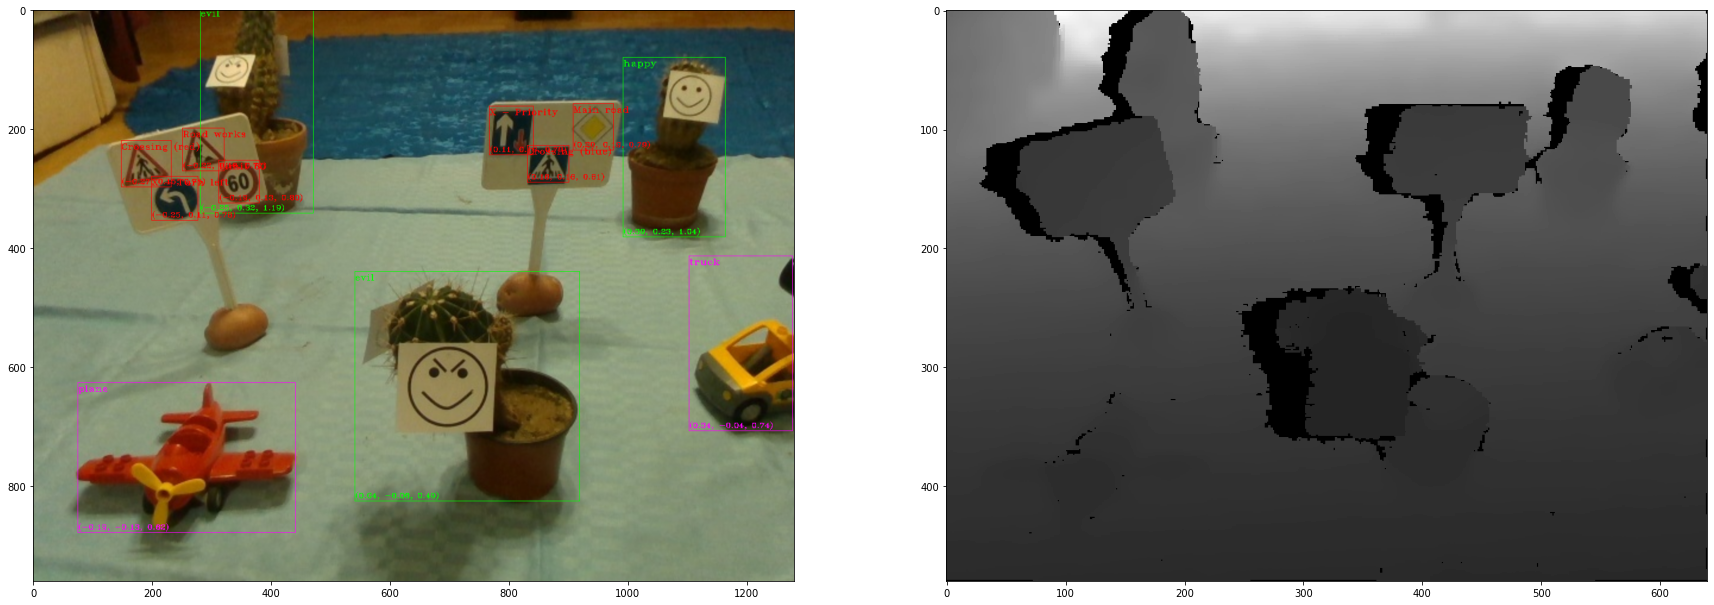

In [14]:
# Display the first images
colors = [(0,0,255),(255,0,255),(0,255,0)]

def drawBBs(BBs, img):
    img = cv2.resize(img, (1280, 960))
    for BB in BBs:
        u = BB[0]*2
        v = BB[1]*2
        w = BB[2]*2
        h = BB[3]*2
        c = BB[4]
        sc = BB[5]
        x = BB[6]
        y = BB[7]
        z = BB[8]
        s = (u - w // 2, v - h // 2)
        e = (u + w // 2, v + h // 2)
        cv2.rectangle(img, s, e, colors[c], 1)
        tl = (s[0], s[1]+15)
        bl = (s[0], e[1]-5)
        cv2.putText(img,subclassNames[c][sc],tl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.75,colors[c])
        coords = "(%.2f, %.2f, %.2f)" % (x,y,z)
        cv2.putText(img,coords,bl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.65,colors[c])
    
    return img

import pickle
import cv2
import matplotlib.pyplot as plt
#This way it doesn't try to open a window un the GUI - works in python notebook
%matplotlib inline

# Read images
img = cv2.imread("/content/HW/g1/rgb/1.jpg")
depth = cv2.imread("/content/HW/g1/depth/1.png", -1)

# Read annotations
file = open('/content/HW/annotations.pickle','rb')
annotations = pickle.load(file)

# Visualization
depth = depth / 5000.0
img = drawBBs(annotations["HW/g1/rgb/1.jpg"]["objects"], img)
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Figure with subplots
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(depth,cmap='gray')

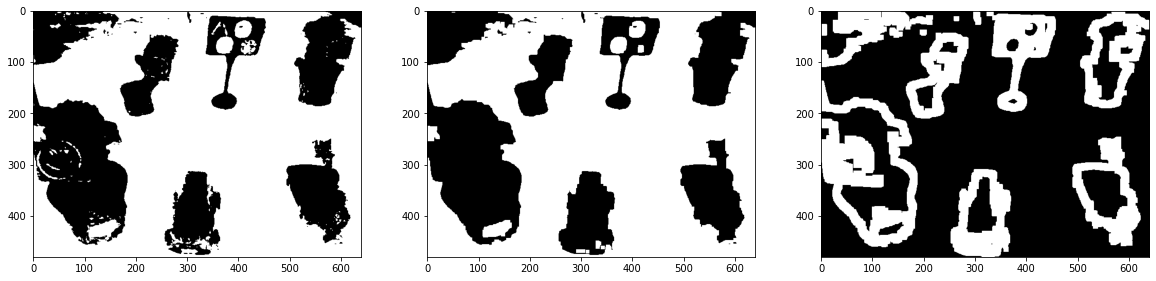

In [15]:
kernel = np.ones((5,5),np.uint8)
nagykernel = np.ones((7,7),np.uint8)
ret, thresh = cv2.threshold(hue_channel_segment,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

fg = cv2.erode(thresh, kernel,iterations=5)
bg = cv2.dilate(thresh, kernel, iterations=2)

opened = cv2.morphologyEx(hue_channel_segment,cv2.MORPH_OPEN,nagykernel)

unknown = cv2.subtract(bg,fg)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(hue_channel_segment,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(opened,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(unknown,cmap='gray')


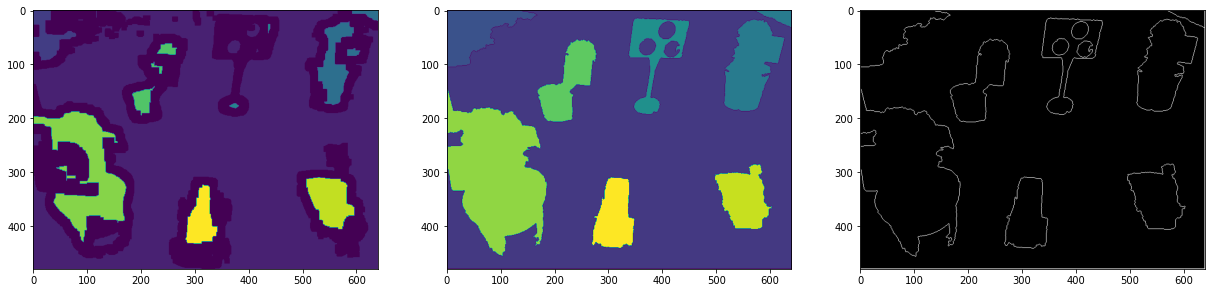

In [77]:
ret, markers = cv2.connectedComponents(bg)
markers=markers+1
markers[unknown==255] = 0
plt.figure(figsize=(21,21))
plt.subplot(1,3,1)
plt.imshow(markers)

imgBGR = cv2.imread("../HW/g3/rgb/136.jpg")

markers = cv2.watershed(imgBGR,markers)
imgBGR[::] =[0,0,0]
imgBGR[markers == -1] = [255,255,255]

plt.subplot(1,3,2)
plt.imshow(markers)
plt.subplot(1,3,3)
plt.imshow(imgBGR)

In [0]:
# markers2 = cv2.cvtColor(markers,cv2.COLOR_BGR2GRAY)

# ret2, thresh2 = cv2.threshold(markers2,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# mask = cv2.dnn_SegmentationModel(markers)

# plt.figure(figsize=(21,21))
# plt.imshow(mask)

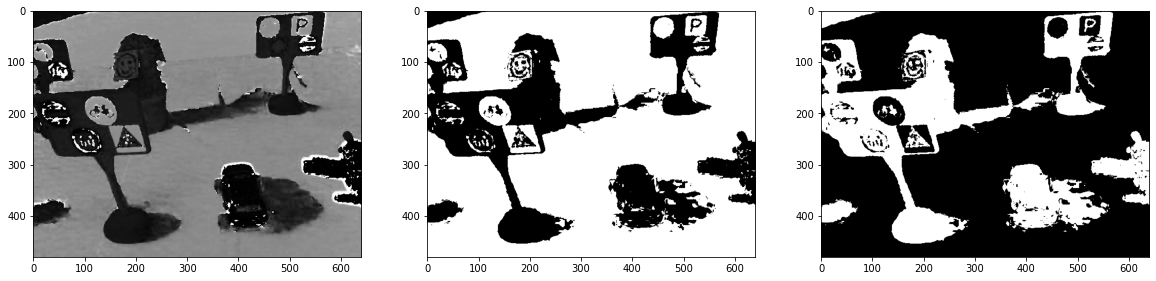

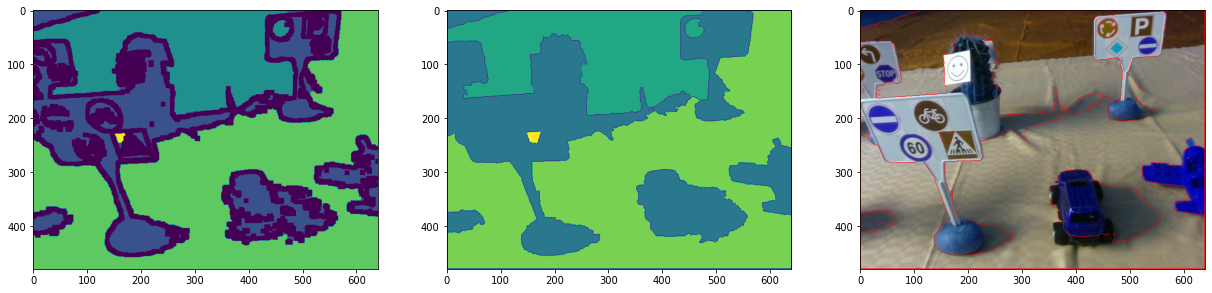

In [228]:
imgBGR = cv2.imread("../HW/g4/rgb/229.jpg") #3 136

imgHSV = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2HSV);
hue_channel = imgHSV[:,:,0]

avg_hue = np.average(hue_channel)
hue_channel_thresh, hue_channel_segment = cv2.threshold(hue_channel,avg_hue*.4,255,cv2.THRESH_BINARY)
#hue_channel_segment = cv2.adaptiveThreshold(hue_channel,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,101,10)

kernel = np.ones((5,5),np.uint8)
nagykernel = np.ones((7,7),np.uint8)
ret, thresh = cv2.threshold(hue_channel_segment,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

fg = cv2.erode(thresh, kernel,iterations=2)
bg = cv2.dilate(thresh, kernel, iterations=2)

opened = cv2.morphologyEx(hue_channel_segment,cv2.MORPH_OPEN ,nagykernel,iterations=3)
closed = cv2.morphologyEx(opened             ,cv2.MORPH_CLOSE,nagykernel,iterations=1)

unknown = cv2.subtract(bg,fg)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(hue_channel,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(hue_channel_segment,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(thresh,cmap='gray')


ret, markers = cv2.connectedComponents(closed)
markers=markers+1
markers[unknown==255] = 0
plt.figure(figsize=(21,21))
plt.subplot(1,3,1)
plt.imshow(markers)


markers = cv2.watershed(imgBGR,markers)
#imgBGR[::] =[0,0,0]
imgBGR[markers == -1] = [255,0,0]

plt.subplot(1,3,2)
plt.imshow(markers)
plt.subplot(1,3,3)
plt.imshow(imgBGR)

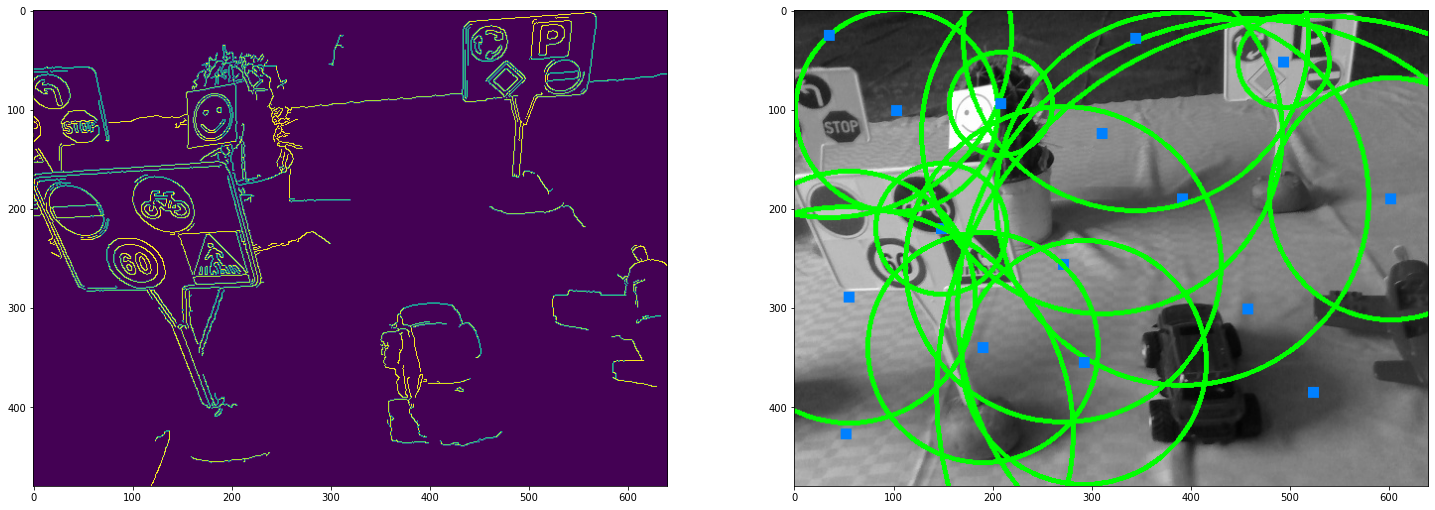

In [206]:
imgBGR = cv2.imread("../HW/g4/rgb/229.jpg") #3 136
imgBGR = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(imgBGR,50,180)

circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT,1.5,100)

# Draw lines on the image
circleIm = cv2.cvtColor(imgBGR,cv2.COLOR_GRAY2BGR)

if circles is not None:
  circles = np.round(circles[0,:]).astype("int")

  for (x,y,r) in circles:
    cv2.circle(circleIm, (x, y), r, (0, 255, 0), 4)
    cv2.rectangle(circleIm, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)



plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(edges)
plt.subplot(1,2,2)
plt.imshow(circleIm)

